# House Prices Sales Prediction - Gianmaria Pizzo



The aforementioned process follows the following steps:

Import Dataset, Headers & Libraries.
Identify Missing Data.
Replace Missing Data.
Evaluate Missing Data.
Dealing with Missing Data.
Correct Data Formats.
Data standardization.
Binning.
Data Normalization.
Indicator variable.

# 1 - Domain Knowledge Section

https://medium.com/@yuneeh/eda-handling-missing-data-with-python-step-by-step-guide-b9df24c4adc3
https://www.itl.nist.gov/div898/handbook/eda/eda.htm


Some of these columns are not useful for our purpose, this is why after an extensive research we understood the main driving factors for house prices:
* Location
    * Neighborhood comps
    * Access to services
* Home size and usable space
* Age and condition
    * Upgrades and updates
* Current Market
    * The local market and economic change
    * Mortgage interest rate
* 
However, we do not have data for each one of those points and most of them are hard to represent in the way the datasets are given to us (even if wanted to add some features of our own).

## Most important features 
Combination of Research + Feature Importance + Error
* Avoid spurious correlations
* Avoid confounders


# 2 - Basic Exploration

## Environment Set Up

In [2]:
%matplotlib notebook
import pandas as pd
import numpy as np
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_toolkits

## Dataset Loading

In [3]:
# TODO: Automatize opening

data = arff.loadarff(r'C:\Users\PayThePizzo\PycharmProjects\pythonProject\resources\ames_housing.arff')
# data = arff.loadarff(r'/Users/gianmariapizzo/PycharmProjects/HouseSalesPricePrediction/resources/ames_housing.arff')
df = pd.DataFrame(data[0])

df.shape

(2930, 81)

We have 2930 objects and 81 columns! That is a lot of data for each single object, we need to find out what are the best ones for the job.

Furthermore, we will need to isolate/hide the sales price in order to avoid overfitting!

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 81 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MS_SubClass         2930 non-null   object 
 1   MS_Zoning           2930 non-null   object 
 2   Lot_Frontage        2930 non-null   float64
 3   Lot_Area            2930 non-null   float64
 4   Street              2930 non-null   object 
 5   Alley               2930 non-null   object 
 6   Lot_Shape           2930 non-null   object 
 7   Land_Contour        2930 non-null   object 
 8   Utilities           2930 non-null   object 
 9   Lot_Config          2930 non-null   object 
 10  Land_Slope          2930 non-null   object 
 11  Neighborhood        2930 non-null   object 
 12  Condition_1         2930 non-null   object 
 13  Condition_2         2930 non-null   object 
 14  Bldg_Type           2930 non-null   object 
 15  House_Style         2930 non-null   object 
 16  Overal

The dataset appears to be very complete, and ready to work with. It has **0 missing information**! This means we can avoid:
* Dropping any of the rwos, for missing important info)
* Dropping columns, for missing more than X% of data.


The features are mostly objects
* 35 `float64`
* 46 `object`

We need to plan for encoding and studying what features can be determinant factors (domain knowledge)


In [85]:
df.head()

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude
0,b'One_Story_1946_and_Newer_All_Styles',b'Residential_Low_Density',141.0,31770.0,b'Pave',b'No_Alley_Access',b'Slightly_Irregular',b'Lvl',b'AllPub',b'Corner',...,b'No_Fence',b'None',0.0,5.0,2010.0,b'WD ',b'Normal',215000.0,-93.619754,42.054035
1,b'One_Story_1946_and_Newer_All_Styles',b'Residential_High_Density',80.0,11622.0,b'Pave',b'No_Alley_Access',b'Regular',b'Lvl',b'AllPub',b'Inside',...,b'Minimum_Privacy',b'None',0.0,6.0,2010.0,b'WD ',b'Normal',105000.0,-93.619756,42.053014
2,b'One_Story_1946_and_Newer_All_Styles',b'Residential_Low_Density',81.0,14267.0,b'Pave',b'No_Alley_Access',b'Slightly_Irregular',b'Lvl',b'AllPub',b'Corner',...,b'No_Fence',b'Gar2',12500.0,6.0,2010.0,b'WD ',b'Normal',172000.0,-93.619387,42.052659
3,b'One_Story_1946_and_Newer_All_Styles',b'Residential_Low_Density',93.0,11160.0,b'Pave',b'No_Alley_Access',b'Regular',b'Lvl',b'AllPub',b'Corner',...,b'No_Fence',b'None',0.0,4.0,2010.0,b'WD ',b'Normal',244000.0,-93.617320,42.051245
4,b'Two_Story_1946_and_Newer',b'Residential_Low_Density',74.0,13830.0,b'Pave',b'No_Alley_Access',b'Slightly_Irregular',b'Lvl',b'AllPub',b'Inside',...,b'Minimum_Privacy',b'None',0.0,3.0,2010.0,b'WD ',b'Normal',189900.0,-93.638933,42.060899


In [7]:
# Geographic Map

BBox = ((df.Longitude.min(), df.Longitude.max()),
         df.Latitude.min(), df.Latitude.max())
BBox

# Let's get the image from https://www.openstreetmap.org/export#map=5/51.500/-0.100
# Or plot with python



((-93.693153, -93.577427), 41.986498, 42.063388)

In [ ]:
# Area
# https://stackoverflow.com/questions/34458251/plot-over-an-image-background-in-python
# https://gisgeography.com/python-libraries-gis-mapping/

In [ ]:
#Save all float64 to new df_numeric
#Save all object to new df_obj


Let us have a quick look at the Sales Prices. In order to add significance to the graph we want to use the colors to indicate the lot of area, and the markers to classify the type of neighborhood.

<IPython.core.display.Javascript object>


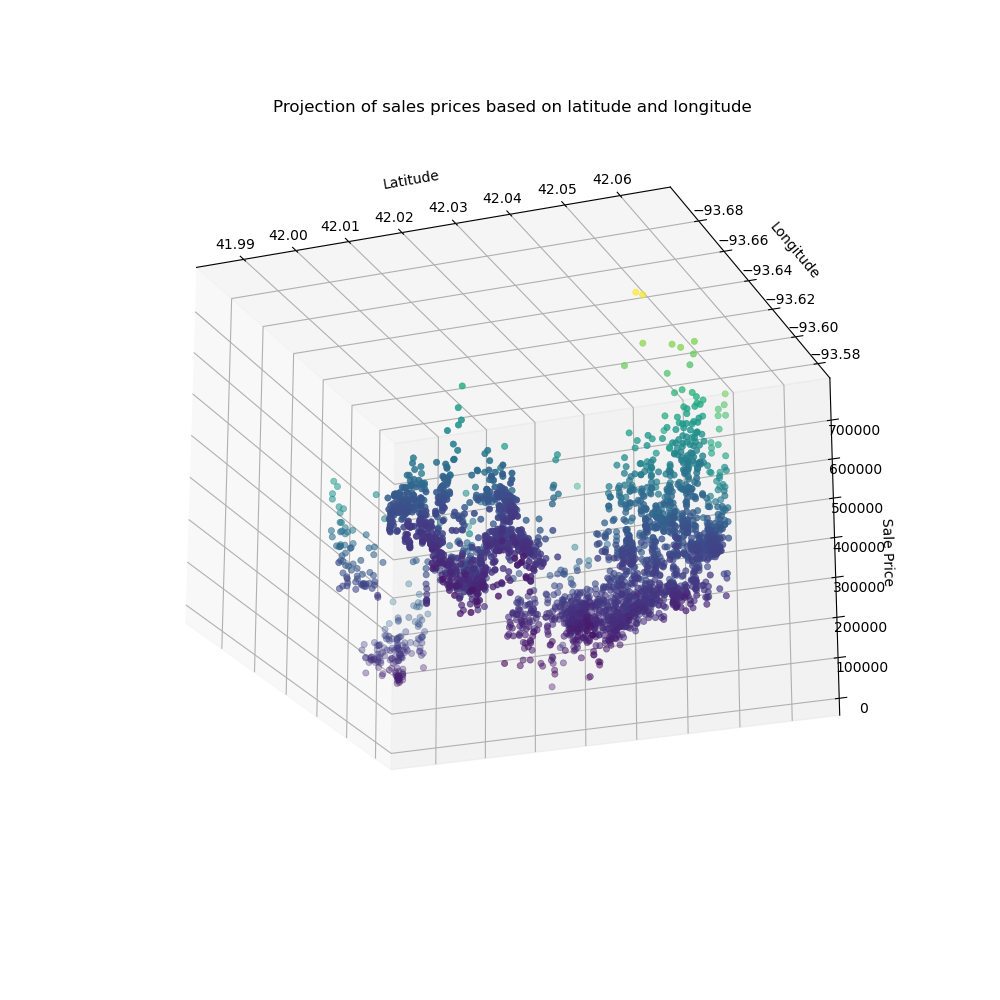

In [8]:
from mpl_toolkits.mplot3d import axes3d

z = df.Sale_Price
x = df.Latitude
y = df.Longitude

# TODO
# marker = Neighborhood
# color = lot_area
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.scatter3D(x, y, z, c=z, cmap='viridis', linewidths=0.5)

ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Sale Price')
ax.set_title('Projection of sales prices based on latitude and longitude')

plt.show()

<IPython.core.display.Javascript object>


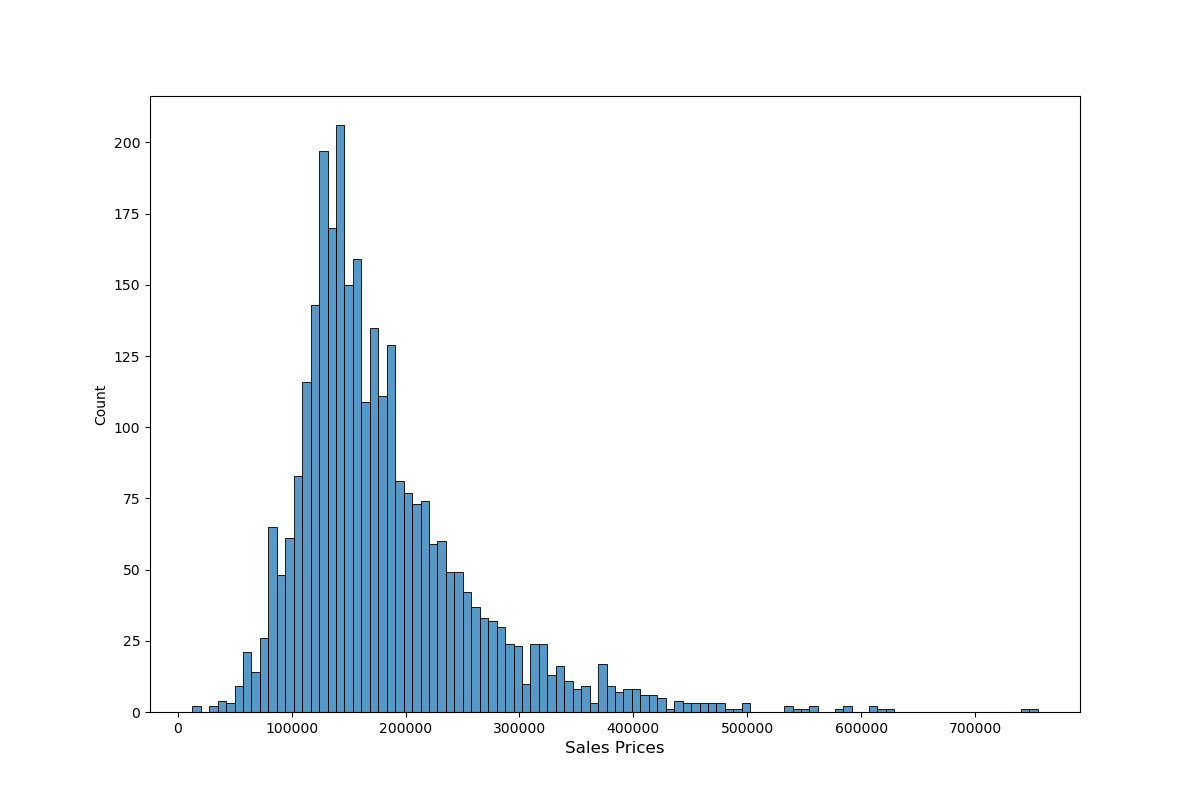

In [12]:
import seaborn as sns

plt.figure(figsize=(12,8))
sns.histplot(df.Sale_Price, bins=100, kde=False)
plt.xlabel('Sales Prices', fontsize=12)
plt.show()

# In-Depth Exploration

## Price change in Years and Months

### Seasonality
https://www.bankrate.com/real-estate/best-time-to-sell-house/

We can easily see that the houses were sold between 2006 and 2010. This means it includes trends of the global state of the economy during the crisis in 2008

We can divide the years by seasons:
1. December-March
2. April-July, which are supposed to be the best time for selling
3. August-November

In [49]:
# To fix
def select_columns(dataset, list_of_cols):
    new_df = dataset[list_of_cols].copy()
    return new_df

def sort_by_col(dataset, list_of_cols):
    sorted_df = dataset.sort_values(by = list_of_cols)
    return sorted_df

def change_col_type(dataset, dict_col_newtype):
    dataset = dataset.astype(dict_col_newtype)
    return dataset

def foo(dataset, list_of_cols, dict_col_newtype):
    newdf = list_of_cols(dataset, list_of_cols)
    newdf = sort_by_col(newdf, list_of_cols)
    newdf = change_col_type(newdf, dict_col_newtype)
    return newdf

time = foo(df, ["Year_Sold", "Mo_Sold", "Sale_Price"], { "Year_Sold" : 'int32', "Mo_Sold" : 'int32'})

time

TypeError: 'list' object is not callable

In [50]:
selected_col = df[["Year_Sold", "Mo_Sold", "Sale_Price"]]
time_df = selected_col.copy()
time_df.sort_values(by=["Year_Sold", "Mo_Sold", "Sale_Price"], inplace=True)
time_df = time_df.astype({ "Year_Sold" : 'int32', "Mo_Sold" : 'int32'})
time_df

,Year_Sold,Mo_Sold,Sale_Price
2703,2006,1,80000.0
2603,2006,1,105000.0
2493,2006,1,120875.0
2541,2006,1,136500.0
2470,2006,1,139500.0
...,...,...,...
25,2010,7,142000.0
35,2010,7,146000.0
256,2010,7,159000.0
136,2010,7,180000.0


In [53]:
def divide_by_seasonality():
    #data structure
    year_stats = []
    for x in range(2006, 2010):
        year_x = time_df.loc[time_df.Year_Sold == x]
        mean = year_x.Sale_Price.mean()
        median = year_x.Sale_Price.median()
        second_quant = year_x.Sale_Price.quantile(q=0.25)
        third_quant = year_x.Sale_Price.quantile(q=0.75)
        # Save info by season
        for y in range (1, 12):
            if y in [1,2,3,12]:

            else if y in [4, 5, 6, 7]:

            else if y in [8, 9, 10, 11]:

        year_stats.append([x, mean, median, second_quant, third_quant])

    return year_stats

mystats = divide_by_seasonality()

plt.hist()

# Result array of 15 elements
# each element with mean, median, min, max

<IPython.core.display.Javascript object>

(array([[1., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
        [1., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
        [1., 0., 0., 0., 0., 1., 0., 1., 1., 1.],
        [1., 0., 0., 0., 0., 1., 0., 1., 1., 1.]]),
 array([  2006. ,  23305.4,  44604.8,  65904.2,  87203.6, 108503. ,
        129802.4, 151101.8, 172401.2, 193700.6, 215000. ]),
 <a list of 4 BarContainer objects>)

In [54]:
mystats

[[2006, 181761.648, 159500.0, 130000.0, 215000.0],
 [2007, 185138.2074927954, 165125.0, 130000.0, 214750.0],
 [2008, 178841.7508038585, 161000.0, 129425.0, 214000.0],
 [2009, 181404.56790123458, 160850.0, 129375.0, 213625.0]]

In [ ]:
# Distribution of Sales' Prices 

## Remove Outliers

# Clustering for distance
We will try and cluster the houses:
1. Find Neighborhood and asses mean price
2. In each Neighborhood, For each house
   * Compare how the change in one important features translates in change in price
   

# Feature Engineering
Based on domain knowledge & Feature importance
* Dropping outliers

## Dropping Outliers

## Dropping Unhelpful Features

## Encoding Categorical Data

## Scaling & Normalization

# Pre-Training Overview
* Model Data
* Show Graphs

# Preparing Train-Test Data

# Prediction - Bagged Random Forest

## Parameter Tuning

## Precision Evaluation & Diagnostics

# Prediction - ANN

## Parameter Tuning

## Precision Evaluation & Diagnostics

# Conclusions
Results
1. Price = Sum(Important Features) + Error
    * Error = Sum(Less Important Feature)
2. Price = Sum(Feature Block + Error)

# Credits & Copyright

Domain Knowledge
 
 @misc{johnson_2022, title={4 best ways to determine home value}, url={https://www.rocketmortgage.com/learn/home-value}, journal={Rocket Mortgage}, author={Johnson, Jamie}, year={2022}, month={Sep}} 
 
  @misc{gomez_2022, title={8 critical factors that influence a home's value}, url={https://www.opendoor.com/w/blog/factors-that-influence-home-value}, journal={Opendoor}, author={Gomez, Joe}, year={2022}, month={Aug}} 
 
Quote bibtex
 https://www.youtube.com/watch?v=m3o1KXA1Rjk
 https://www.bibme.org/
 


### TODO
* Check for plagiarism
* Rephrase

In [23]:
has_pool = df.loc[df.Pool_Area > 0.0]